In [1]:
import pandas as pd
from os.path import join
from training import dataset
import os
import click
import tqdm.auto as tqdm    
import pickle
import numpy as np
import scipy.linalg
import torch
import dnnlib
from torch_utils import distributed as dist
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
import re
import pandas as pd

def parse_sampler_string(s):
    """
    Parses a sampler string into its components: solver_name, steps, and skip_value.

    Parameters:
    - s (str): The sampler string to parse.

    Returns:
    - dict: A dictionary containing the parsed components.
    """
    # Regular expression pattern to match the string structure
    pattern = r'^(.+?)_(\d+)_skip([\d\.]+)$'
    match = re.match(pattern, s)
    if match:
        solver_name = match.group(1)
        steps = int(match.group(2))
        skip_value = float(match.group(3))
        return {
            'solver_name': solver_name,
            'steps': steps,
            'skip_value': skip_value
        }
    else:
        # Handle cases where the string doesn't match the expected pattern
        return {
            'solver_name': None,
            'steps': None,
            'skip_value': None
        }


In [2]:
fid_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/fid-refs"
refdata_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/datasets"
sample_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/edm_analy_sampler_benchmark/samples/"
eval_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/edm_analy_sampler_benchmark/eval/"
model_ckpt_dict = {"afhqv264": "edm-afhqv2-64x64-uncond-vp",
                   "ffhq64": "edm-ffhq-64x64-uncond-vp",
                   "cifar10": "edm-cifar10-32x32-uncond-vp"}
refdata_dict = {"afhqv264": "afhqv2-64x64.zip",
                "ffhq64": "ffhq-64x64.zip",
                "cifar10": "cifar10-32x32.zip"}
refstats_dict = {"afhqv264": "afhqv2-64x64.npz",
                "ffhq64": "ffhq-64x64.npz",
                "cifar10": "cifar10-32x32.npz"}
refstats_url_dict = {"ffhq64": "https://nvlabs-fi-cdn.nvidia.com/edm/fid-refs/ffhq-256.npz",
            "afhqv264": "https://nvlabs-fi-cdn.nvidia.com/edm/fid-refs/afhqv2-64x64.npz",
            "cifar10": "https://nvlabs-fi-cdn.nvidia.com/edm/fid-refs/cifar10-32x32.npz"}


In [ ]:
from circuit_toolkit.plot_utils import saveallforms

In [ ]:
synopsis_dir = join(eval_root, "synopsis")
os.makedirs(synopsis_dir, exist_ok=True)

### CIFAR10

In [31]:
dataset = "cifar10"
eval_dir = join(eval_root, model_ckpt_dict[dataset])
!basename {eval_dir}/*.
fid_stats_df = pd.read_csv(join(eval_dir, "fid_by_sampler.csv"), index_col=0)

fid_by_sampler.csv


In [15]:
# Example usage with your dataframe column
fid_stats_df_parsed = fid_stats_df.copy()
# Assuming fid_stats_df is your DataFrame
fid_stats_df_parsed['parsed_sampler'] = fid_stats_df_parsed['sampler'].apply(parse_sampler_string)
# If you want to expand the parsed components into separate columns
fid_stats_df_parsed = fid_stats_df_parsed.join(fid_stats_df_parsed['parsed_sampler'].apply(pd.Series))
fid_stats_df_parsed.drop(columns=["parsed_sampler"], inplace=True)
# Now you have 'solver_name', 'steps', and 'skip_value' as separate columns in your DataFrame

In [16]:
fid_stats_df_parsed

,sampler,fid,dataset,solver_name,steps,skip_value
0,dpm_solver++_10_skip1.0,29.337165,cifar10,dpm_solver++,10,1.0
1,dpm_solver++_10_skip10.0,2.940802,cifar10,dpm_solver++,10,10.0
2,dpm_solver++_10_skip2.5,7.229553,cifar10,dpm_solver++,10,2.5
3,dpm_solver++_10_skip20.0,2.841849,cifar10,dpm_solver++,10,20.0
4,dpm_solver++_10_skip40.0,2.833573,cifar10,dpm_solver++,10,40.0
...,...,...,...,...,...,...
275,uni_pc_bh2_8_skip2.5,8.701084,cifar10,uni_pc_bh2,8,2.5
276,uni_pc_bh2_8_skip20.0,3.504614,cifar10,uni_pc_bh2,8,20.0
277,uni_pc_bh2_8_skip40.0,3.528143,cifar10,uni_pc_bh2,8,40.0
278,uni_pc_bh2_8_skip5.0,4.875680,cifar10,uni_pc_bh2,8,5.0


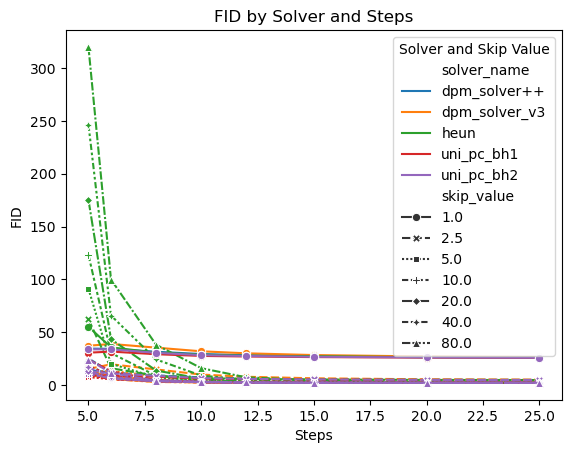

In [21]:
# fid_stats_df_parsed.plot(x="steps", y="fid", hue="solver_name", style="skip_value", markers=True, figsize=(10, 6))
sns.lineplot(x="steps", y="fid", hue="solver_name", style="skip_value", markers=True, data=fid_stats_df_parsed)
plt.title("FID by Solver and Steps")
plt.xlabel("Steps")
plt.ylabel("FID")
plt.legend(title="Solver and Skip Value")
plt.show()


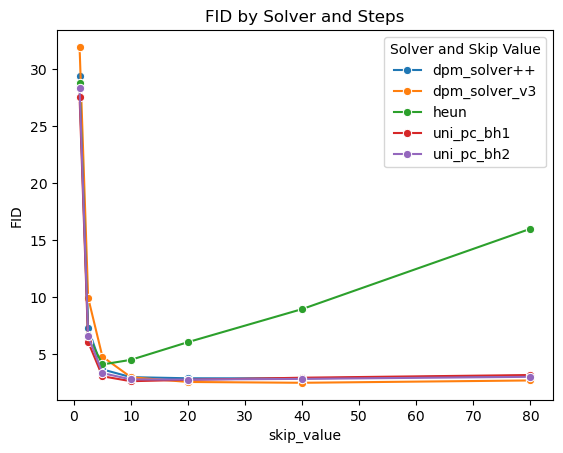

In [24]:
# fid_stats_df_parsed.plot(x="steps", y="fid", hue="solver_name", style="skip_value", markers=True, figsize=(10, 6))
sns.lineplot(x="skip_value", y="fid", hue="solver_name", markers=True, marker="o",
             data=fid_stats_df_parsed.query("steps == 10"))
plt.title("FID by Solver and Steps")
plt.xlabel("skip_value")
plt.ylabel("FID")
plt.legend(title="Solver and Skip Value")
plt.show()

In [25]:
fid_stats_df_parsed.head()


,sampler,fid,dataset,solver_name,steps,skip_value
0,dpm_solver++_10_skip1.0,29.337165,cifar10,dpm_solver++,10,1.0
1,dpm_solver++_10_skip10.0,2.940802,cifar10,dpm_solver++,10,10.0
2,dpm_solver++_10_skip2.5,7.229553,cifar10,dpm_solver++,10,2.5
3,dpm_solver++_10_skip20.0,2.841849,cifar10,dpm_solver++,10,20.0
4,dpm_solver++_10_skip40.0,2.833573,cifar10,dpm_solver++,10,40.0


In [35]:
fid_stats_df_parsed.solver_name.unique()

array(['dpm_solver++', 'dpm_solver_v3', 'heun', 'uni_pc_bh1',
       'uni_pc_bh2'], dtype=object)

In [43]:
fid_stats_df_parsed.to_csv(join(synopsis_dir, f"{dataset}_fid_stats_df_parsed.csv"))

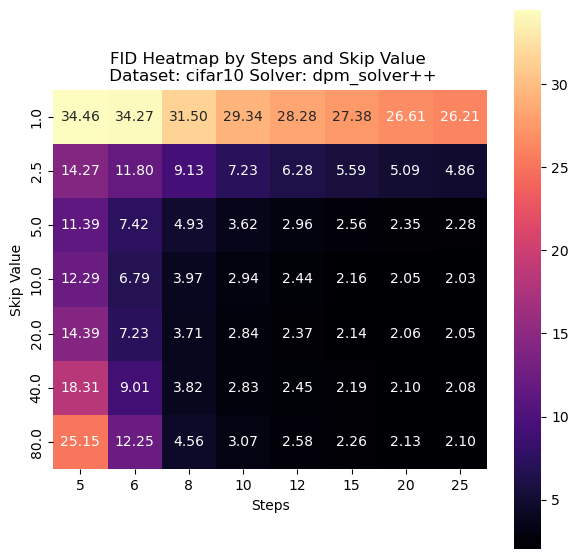

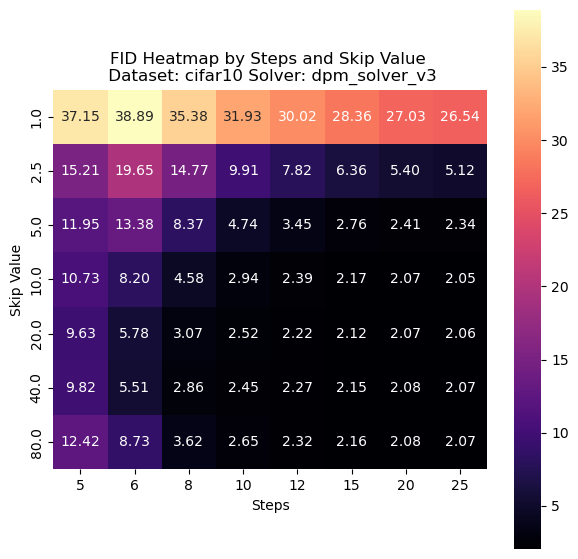

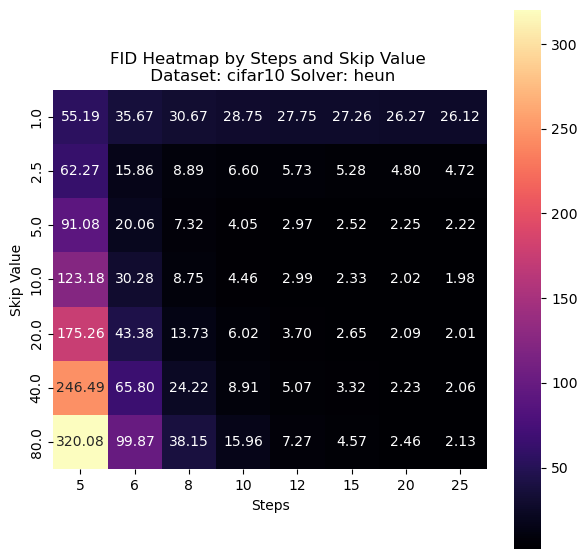

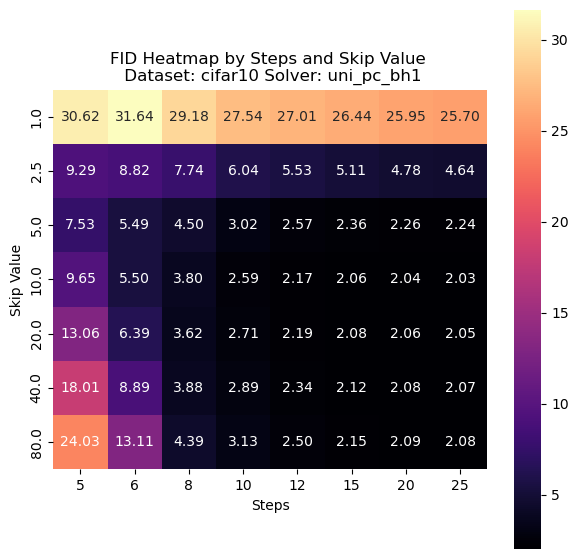

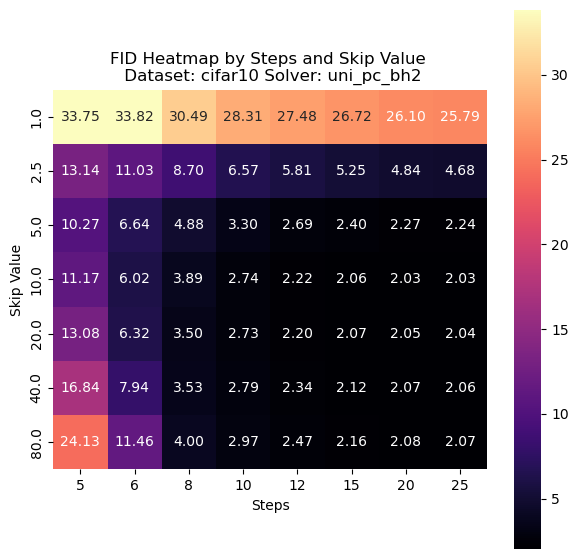

In [44]:
for solver_name in fid_stats_df_parsed.solver_name.unique():
    # Pivot the DataFrame
    pivot_df = fid_stats_df_parsed.query(f"solver_name == '{solver_name}'").\
        pivot(index='skip_value', columns='steps', values='fid')
    # Sort the columns and index for better visualization
    pivot_df = pivot_df.sort_index(axis=1)
    pivot_df = pivot_df.sort_index(axis=0)
    plt.figure(figsize=(7, 7))
    sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="magma")
    plt.title(f"FID Heatmap by Steps and Skip Value \n Dataset: {dataset} Solver: {solver_name}")
    plt.ylabel("Skip Value")
    plt.xlabel("Steps")
    plt.axis("image")
    saveallforms(synopsis_dir, f"{dataset}_{solver_name}_fid_heatmap_skip_steps")
    plt.show()


### AFHQ

In [46]:
model_ckpt_dict

{'afhqv264': 'edm-afhqv2-64x64-uncond-vp',
 'ffhq64': 'edm-ffhq-64x64-uncond-vp',
 'cifar10': 'edm-cifar10-32x32-uncond-vp'}

In [48]:
dataset = "afhqv264"
eval_dir = join(eval_root, model_ckpt_dict[dataset])
!basename {eval_dir}/*.csv
fid_stats_df = pd.read_csv(join(eval_dir, "fid_by_sampler.csv"), index_col=0)

fid_by_sampler.csv


In [49]:
# Example usage with your dataframe column
fid_stats_df_parsed = fid_stats_df.copy()
# Assuming fid_stats_df is your DataFrame
fid_stats_df_parsed['parsed_sampler'] = fid_stats_df_parsed['sampler'].apply(parse_sampler_string)
# If you want to expand the parsed components into separate columns
fid_stats_df_parsed = fid_stats_df_parsed.join(fid_stats_df_parsed['parsed_sampler'].apply(pd.Series))
fid_stats_df_parsed.drop(columns=["parsed_sampler"], inplace=True)
# Now you have 'solver_name', 'steps', and 'skip_value' as separate columns in your DataFrame
fid_stats_df_parsed.to_csv(join(synopsis_dir, f"{dataset}_fid_stats_df_parsed.csv"))

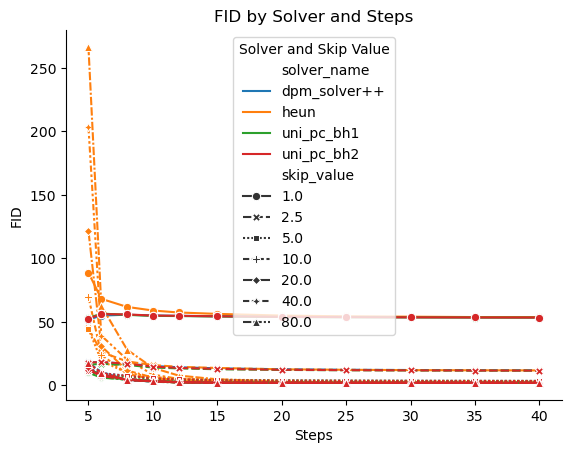

In [50]:
# fid_stats_df_parsed.plot(x="steps", y="fid", hue="solver_name", style="skip_value", markers=True, figsize=(10, 6))
sns.lineplot(x="steps", y="fid", hue="solver_name", style="skip_value", markers=True, data=fid_stats_df_parsed)
plt.title("FID by Solver and Steps")
plt.xlabel("Steps")
plt.ylabel("FID")
plt.legend(title="Solver and Skip Value")
plt.show()


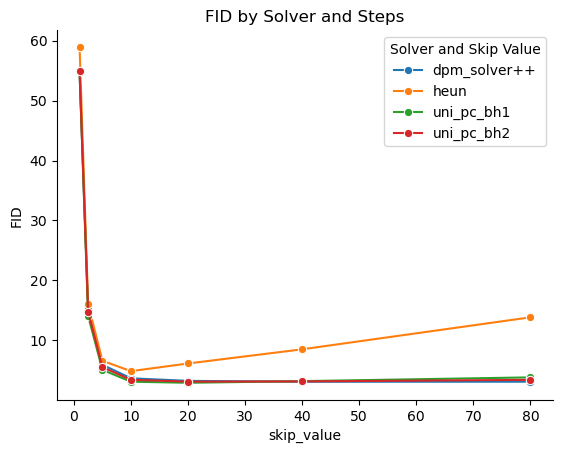

In [51]:
# fid_stats_df_parsed.plot(x="steps", y="fid", hue="solver_name", style="skip_value", markers=True, figsize=(10, 6))
sns.lineplot(x="skip_value", y="fid", hue="solver_name", markers=True, marker="o",
             data=fid_stats_df_parsed.query("steps == 10"))
plt.title("FID by Solver and Steps")
plt.xlabel("skip_value")
plt.ylabel("FID")
plt.legend(title="Solver and Skip Value")
plt.show()

In [52]:
fid_stats_df_parsed.solver_name.unique()

array(['dpm_solver++', 'heun', 'uni_pc_bh1', 'uni_pc_bh2'], dtype=object)

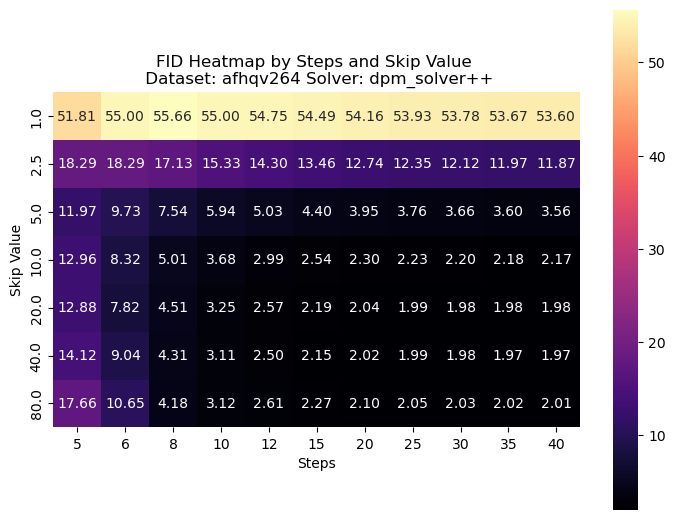

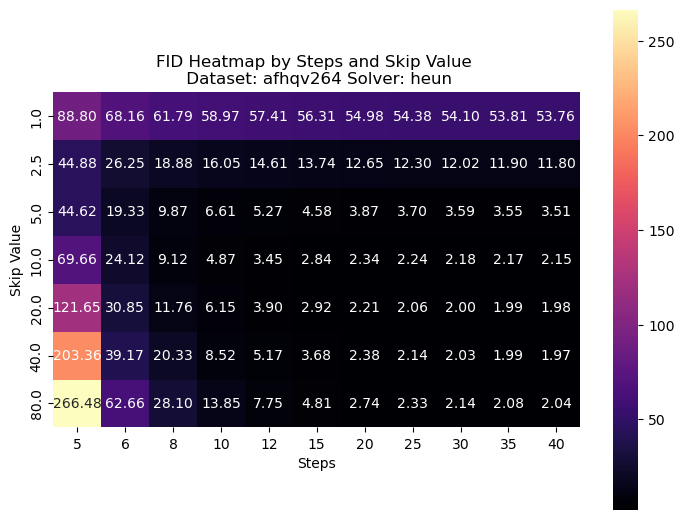

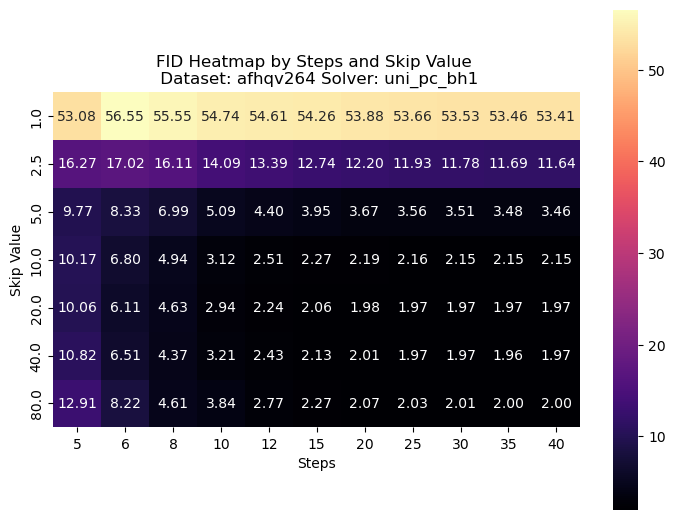

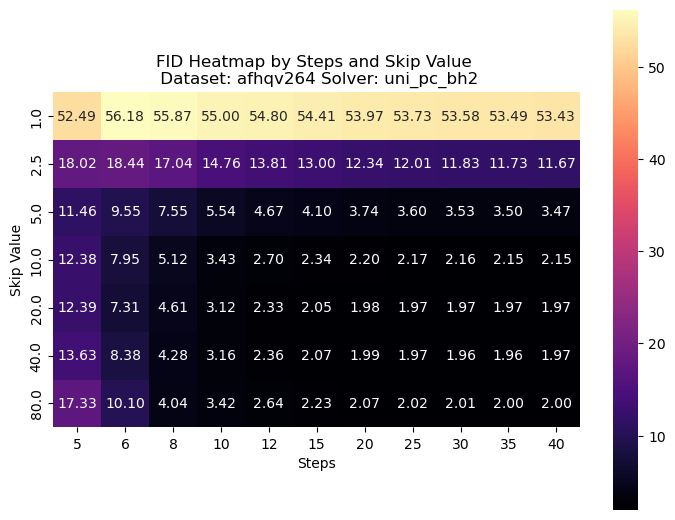

In [55]:
for solver_name in fid_stats_df_parsed.solver_name.unique():
    # Pivot the DataFrame
    pivot_df = fid_stats_df_parsed.query(f"solver_name == '{solver_name}'").\
        pivot(index='skip_value', columns='steps', values='fid')
    # Sort the columns and index for better visualization
    pivot_df = pivot_df.sort_index(axis=1)
    pivot_df = pivot_df.sort_index(axis=0)
    plt.figure(figsize=(8.5, 6.5))
    sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="magma")
    plt.title(f"FID Heatmap by Steps and Skip Value \n Dataset: {dataset} Solver: {solver_name}")
    plt.ylabel("Skip Value")
    plt.xlabel("Steps")
    plt.axis("image")
    saveallforms(synopsis_dir, f"{dataset}_{solver_name}_fid_heatmap_skip_steps")
    plt.show()


### FFHQ